In [1]:
import numpy as np
import seaborn as sns
from dask.distributed import Client
from distributed.deploy.local import LocalCluster
from pycalphad import Database,calculate,equilibrium,variables as v
from espei.utils import database_symbols_to_fit
import matplotlib.pyplot as plt
from collections import OrderedDict
import xarray as xr
import matplotlib.pyplot as plt
from pycalphad import calculate
import numpy as np
import seaborn as sns
import xarray as xr
from espei.core_utils import get_data
from espei.utils import database_symbols_to_fit
from collections import OrderedDict
from scipy.stats import gaussian_kde
sns.set(color_codes=True)

In [2]:
def plot_property_acr(dbf, comps, phaseL,phaseref, params, T, prop,
                  config=None, datasets=None, xlim=None,
                  xlabel=None, ylabel=None, yscale=None,
                  phase_label_dict=None,
                  unit='kJ/mol.', cdict=None, figsize=None,ref_ele=None,comt=None):

    """
    Plot a property of interest versus temperature with uncertainty
    bounds for all phases of interest

    Parameters
    ----------
    dbf : Database
        Thermodynamic database containing the relevant parameters
    comps : list
        Names of components to consider in the calculation
    phaseL : list
        Names of phases to plot properties for
    params : numpy array
        Array where the rows contain the parameter sets
        for the pycalphad equilibrium calculation
    T : list, array or x-array object
        Temperature values at which to plot the selected property
    prop : str
        property (or attribute in pycalphad terminology) to sample,
        e.g. GM for molar gibbs energy or H_MIX for the enthalpy of
        mixing
    config : tuple, optional
        Sublattice configuration as a tuple, e.g. (“CU”, (“CU”, “MG”))
    datasets : espei.utils.PickleableTinyDB, optional
        Database of datasets to search for data
    xlims : list or tuple of float, optional
        List or tuple with two floats corresponding to the
        minimum and maximum molar composition of comp
    xlabel : str, optional
        plot x label
    ylabel : str, optional
        plot y label
    yscale : int or float, optional
        scaling factor to apply to property (e.g. to plot kJ/mol.
        instead of J/mol. choose yscale to be 0.001)
    phase_label_dict : dict, optional
        Dictionary with keys given by phase names and corresponding
        strings to use in plotting (e.g. to enable LaTeX labels)
    unit : str, optional
        Unit to plot on the y-axis for the property of interest
    cdict : dict, optional
        Dictionary with phase names and corresponding
        colors
    figsize : tuple or list of int or float, optional
        Plot dimensions in inches

    Returns
    -------

    Examples
    --------
    >>> import numpy as np
    >>> import pduq.uq_plot as uq
    >>> from pycalphad import Database
    >>> dbf = Database('CU-MG_param_gen.tdb')
    >>> comps = ['MG', 'CU', 'VA']
    >>> phaseL = ['CUMG2', 'LIQUID']
    >>> params = np.loadtxt('params.npy')[: -1, :]
    >>> T = 650
    >>> prop = 'GM'
    >>> # Plot the molar gibbs energy of all phases in phaseL
    >>> # versus molar fraction of MG at 650K. This will have
    >>> # uncertainty intervals generated by the parameter sets
    >>> # in params
    >>> uq.plot_property(dbf, comps, phaseL, params, T, prop)
    """

    symbols_to_fit = database_symbols_to_fit(dbf)

    CI = 95
    nph = len(phaseL)
    colorL = sns.color_palette("cubehelix", nph)
    markerL = 10*['o', 'D', '^', 'x', 'h', 's',
                  'v', '*', 'P', 'p', '>', 'd', '<']

    plt.figure(figsize=figsize)
    
    # compute uncertainty in property for each phase in list
    #for ii in range(nph):


        # for each parameter sample calculate the property
        # for each possible site occupancy ratios
    compL = []
    for index in range(params.shape[0]):
        param_dict = {param_name: param for param_name, param
                          in zip(symbols_to_fit, params[index, :])}
        parameters = OrderedDict(sorted(param_dict.items(), key=str))
            

        ref_eq = equilibrium(dbf, comps, phaseref, {v.P: 101325, v.T: T, v.X(ref_ele): 1},parameters=parameters)
               
        eq = equilibrium(dbf, comps, phaseL,{v.P: 1013325, v.T: T, v.X(ref_ele): (0.02, 0.1, 0.001)},parameters=parameters)
                
        chempot_ref = ref_eq.MU.sel(component=comt).squeeze()
        chempot = eq.MU.sel(component=comt).squeeze()
                
        comp = np.exp((chempot - chempot_ref)/(8.31451*T))


        compL += [comp]
        
        # concatenate the calculate results in an xarray along
        # an axis named 'sample'
    compC = xr.concat(compL, 'sample')
    compC.coords['sample'] = np.arange(params.shape[0])
        

        # The composition vector is the same for all samples
    if hasattr(T, "__len__"):
            Xvals = T
    else:

        Xvals=eq.X.sel(component=comt, vertex=0).values.squeeze()
        print(Xvals)
        print(Xvals.shape())
        Pvals = compC.values.squeeze()    
        if np.array(Xvals).size == 1:
            print('phase is a line compound')
            Xvals_ = np.array([Xvals-0.002, Xvals+0.002])
            Pvals_ = np.vstack([Pvals, Pvals]).T
        else:
            # find the lower hull of the property by finding
            # the configuration with the lowest value within
            # each interval. In each interval record the composition
            # and property
            Pvals_1= np.nan_to_num(Pvals)
            
            index=np.sum(Pvals_1, axis=1)
            index_=[]
            print('Pvals=',Pvals_1)
            for ll in range(len(Pvals_1)):
                #if 0 in Pvals_1[ll] or index[ll]==0:
                if index[ll]==0:
                    index_.append(ll)
            print('index=',index)
            print('index_=',index_)
            print('Pvals_ori=',Pvals_1)
            print('Pvals=',Pvals_1.shape)
            Pvals_=np.delete(Pvals_1,index_,0)
            print('Pvals=',Pvals_)
            CI=100
            low, mid, high = np.percentile(
             Pvals_, [0.5*(100-CI), 50, 100-0.5*(100-CI)], axis=0)
            print('low',low)
            print('high',high)
            print('mean',mid)
        if cdict is not None:
            color = cdict[phase]
        else:
            color = colorL[0]

        if phase_label_dict is not None:
            label = phase_label_dict[phase]
        else:
            label = 'Cal'
        Xvals_=Xvals
        print('x',Xvals)
        plt.plot(Xvals_, np.log(mid), linestyle='-', color=color, label=label)
        plt.fill_between(
            np.atleast_1d(Xvals_), np.log(low), np.log(high), alpha=0.3, facecolor=color)
        result_data=[Xvals_,low,mid,high]
        np.savetxt('results.txt',result_data)

        # collect and plot experimental data

    if xlim is None:
        plt.xlim([Xvals_.min(), Xvals_.max()])
    else:
        plt.xlim(xlim)

    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(r'$X_{%s}$' % comps[0])

    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(prop + ' (' + unit + ')')

    plt.legend()
    plt.tight_layout()

/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/

/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/

/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum
/Users/sunhui/opt/anaconda3/envs/PDUQ/lib/python3.6/site-packages/pycalphad/

[0.02  0.021 0.022 0.023 0.024 0.025 0.026 0.027 0.028 0.029 0.03  0.031
 0.032 0.033 0.034 0.035 0.036 0.037 0.038 0.039 0.04  0.041 0.042 0.043
 0.044 0.045 0.046 0.047 0.048 0.049 0.05  0.051 0.052 0.053 0.054 0.055
 0.056 0.057 0.058 0.059 0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067
 0.068 0.069 0.07  0.071 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079
 0.08  0.081 0.082 0.083 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091
 0.092 0.093 0.094 0.095 0.096 0.097 0.098 0.099]
Pvals= [[4.68923298e-12 4.87596764e-12 5.06017784e-12 ... 2.44019288e-11
  2.49242723e-11 2.54610634e-11]
 [1.66950495e-13 1.76237865e-13 1.85663112e-13 ... 2.28987063e-12
  2.36296773e-12 2.43857845e-12]
 [3.91851422e-11 4.09980717e-11 4.28075266e-11 ... 2.71002387e-10
  2.77191650e-10 2.83543829e-10]
 ...
 [4.22355497e-12 4.42092457e-12 4.61819263e-12 ... 3.19701828e-11
  3.27604072e-11 3.35732158e-11]
 [3.31114667e-13 3.48260919e-13 3.65557387e-13 ... 3.63631486e-12
  3.74420781e-12 3.85564870e-12]
 [6.3

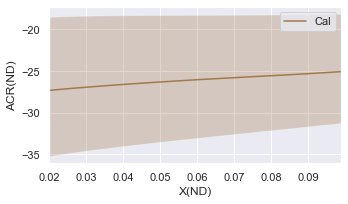

In [3]:
dbf = Database('ESPEI_mcmc_resACI1.tdb')
params = np.load('trace1.npy')[:, -1, :]
params = params.reshape(-1,params.shape[-1])
phaseL = [ 'LIQUID']
phaseref=['DHCP']
comps = ['BI', 'ND', 'VA']  # species to consider
T = 973  # temperature in Kelvin
prop = 'ACR'  # property of interest (molar Gibbs energy)
ref_ele = 'ND'
comt = 'ND'
xlabel = 'X(ND)'
ylabel = 'ACR(ND)'  # y-axis label
# yscale = 1e-3  # we want to scale the Gibbs energy to give kJ/mol.
# we can now plot the property. Note that phaseL, phase_label_dict,
# and cdict are defined in the phase diagram prediction example

plot_property_acr(dbf, comps, phaseL,phaseref, params, T, prop,xlabel=xlabel,
                 ylabel=ylabel,ref_ele=ref_ele,comt= comt,
                 figsize=(5, 3))

In [ ]:
dbf = Database('ESPEI_mcmc_resACI_final.tdb')
params = np.load('trace_1.npy')[:, -1, :]
params = params.reshape(-1,params.shape[-1])
phaseL = [ 'LIQUID','DHCP']
phaseref = ['BCC_A2', 'LIQUID','DHCP','RHOMBOHEDRAL_A7','BIND2']
comps = ['BI', 'ND', 'VA']  # species to consider
T = 973  # temperature in Kelvin
prop = 'ACR'  # property of interest (molar Gibbs energy)
ref_ele = 'ND'
comt = 'ND'
xlabel = 'X(ND)'
ylabel = 'ACR(ND)'  # y-axis label
yscale = 1e-3  # we want to scale the Gibbs energy to give kJ/mol.
# we can now plot the property. Note that phaseL, phase_label_dict,
# and cdict are defined in the phase diagram prediction example

plot_property_acr(dbf, comps, phaseL, phaseref, params, T, prop,xlabel=xlabel,
                 ylabel=ylabel, yscale=yscale,ref_ele=ref_ele,comt= comt,
                 figsize=(5, 3))